In [1]:
import csv
import os
import json
import re
import string
import nltk
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [2]:
import pandas as pd
import numpy as np
import random
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [3]:
# preprocess text by:
# 1. convert to lowercase
# 2. removing numbers/punctuation/whitespaces
# 3. tokenization and removing stop words
# 4. Stemming/Lemmatization

def preprocess(s):
    text = s.lower().strip()
    text = re.sub(r'\d+','',text)
    text = re.sub(r'[^\w\s]','',text)
    tokens = nltk.word_tokenize(text)
    lemmatizer = nltk.stem.WordNetLemmatizer()
    stemmer = nltk.stem.PorterStemmer()
    res = [(stemmer.stem(lemmatizer.lemmatize(i))) for i in tokens if not i in set(ENGLISH_STOP_WORDS)]
    return res


In [4]:
# test preprocess

a = preprocess("   abCDE FgH")
print(a)
b = preprocess("3j,f 34 [.k]  saf! #fe3")
print(b)
c = preprocess("testing the stopwords a in the woods had been mouse mice walking")
print(c)
d = preprocess("In some cases, it’s necessary to remove sparse terms or particular words from texts. This task can be done using stop words removal techniques considering that any group of words can be chosen as the stop words.")
print(d)

['abcd', 'fgh']
['jf', 'k', 'saf', 'fe']
['test', 'stopword', 'wood', 'mous', 'mous', 'walk']
['case', 'necessari', 'remov', 'spars', 'term', 'particular', 'word', 'text', 'task', 'use', 'stop', 'word', 'remov', 'techniqu', 'consid', 'group', 'word', 'chosen', 'stop', 'word']


In [5]:
# use preprocessed text to yield best result in feature extraction with TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

def extract_features(corpus):
    vectorizer = TfidfVectorizer(min_df=0.01, max_df=0.99, ngram_range=(1,2))
    matrix = vectorizer.fit_transform(corpus)
    
    print('Data shape: ', matrix.shape)
    
    return matrix, vectorizer

In [6]:
# primarily use metadata.csv, access full text in document_parses/
# add preprocessed text into "corpus" and run TF-IDF on corpus

# UPDATE: use abstracts instead of full text documents

d = []
j = []
with open('CORD/metadata.csv') as f:
    reader = csv.DictReader(f)
    for row in reader:
#       if row['pdf_json_files']:
#            for json_path in row['pdf_json_files'].split('; '):
#                with open('CORD/'+json_path) as jfile:
#                    text = json.load(jfile)
#                    fulltext = ""
#                    for paragraph in text['body_text']:
#                        fulltext += paragraph['text'] + " "
#                    documents.append(fulltext)
        if row['abstract']:
            d.append(row['abstract'])
            j.append(row['journal'])
    print('Number of documents:', len(d))
    print('Number of journals:', len(j))
    print('Unique journals:', len(np.unique(j)))

Number of documents: 318352
Number of journals: 318352
Unique journals: 28579


In [7]:
# sample a subset of documents and get their corresponding journals

ind = random.sample(range(0,len(d)),20000)
documents = [d[i] for i in ind]
journals = [j[i] for i in ind]
print('Number of documents:', len(documents))
print('Number of journals:', len(journals))
print('Unique journals:', len(np.unique(journals)))

Number of documents: 20000
Number of journals: 20000
Unique journals: 7632


In [8]:
corpus = []
for doc in documents:
    processed = preprocess(doc)
    corpus.append(" ".join(processed))

In [9]:
# matrix is our TF-IDF data that will be fed into our algorithms
# rows correspond to the documents, columns contain the TF-IDF for the feature in each document

X, vectorizer = extract_features(corpus)
features = vectorizer.get_feature_names()
matrix = X.todense()

Data shape:  (20000, 1545)


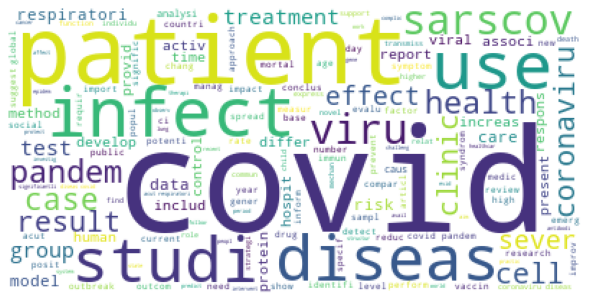

In [10]:
# build wordcloud from corpus, gives us most common words in our sampled dataset

df = pd.DataFrame(matrix,columns=vectorizer.get_feature_names())
cloud = WordCloud(background_color="white", max_words=150).generate_from_frequencies(df.T.sum(axis=1))

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(cloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

#  K-Means Clustering

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [30]:
# expirement with different number of clusters

kvals = np.arange(17,26)

models = []
for k in kvals:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(matrix)
    models.append(kmeans)

## silhouette score evaluation

In [31]:
# calculate silhouette_score for each number cluster model
# The score ranges between -1 and 1: 
# a score of 1 suggests the means clusters are clearly distinguishable and well apart from each other
# a score of 0 suggests the distance between clusters is insignificant
# a score of -1 indicates wrong assignments of means clusters.

for i in range(len(models)):
    score = silhouette_score(matrix, models[i].labels_)
    print('For k =',kvals[i],' -- silhouette score is', score)

KeyboardInterrupt: 

## elbow method evaluation

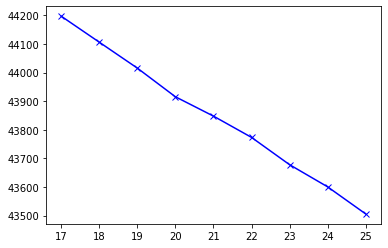

In [32]:
# The optimal number of clusters is achieved when the addition of a new cluster doesn't 
# significantly increases the cost function
# This usually happens on the 'elbow' of the line.

ssd = []
for model in models:
    ssd.append(model.inertia_)
plt.plot(kvals, ssd, 'bx-')
plt.show()

## Journal Evaluation

With meaningful clustering, we expect to find some sort of correlation with the journals that the abstracts are from. For example, one cluster contains a majority of documents from Journal A, while another cluster contains a lot of documents from Journal B. We hopefully see a majority of documents in each cluster to come from fewer number journals, whereas we expect a much bigger variety of journals from random clustering.

In [12]:
def top_journals_per_cluster(predictions, n_journals):
    res = []
    labels = np.unique(predictions)
    for label in labels:
        ind = np.where(predictions==label)[0] # get indices from resulting predictions with the current label
        jour = [journals[i] for i in ind] # extract the corresponding journals
        unique, counts = np.unique(jour, return_counts=True) # record the counts for each unique journal of current label
        top_id = np.argsort(counts)[::-1][:n_journals] # get indices of top n_journal counts
        top_j = [(jour[i], counts[i]) for i in top_id] # store journal name and counts for the top n_journals
        df = pd.DataFrame(top_j, columns=['journal','counts']) 
        res.append(df)
    return res

### Evaluate kmeans-trained clusters

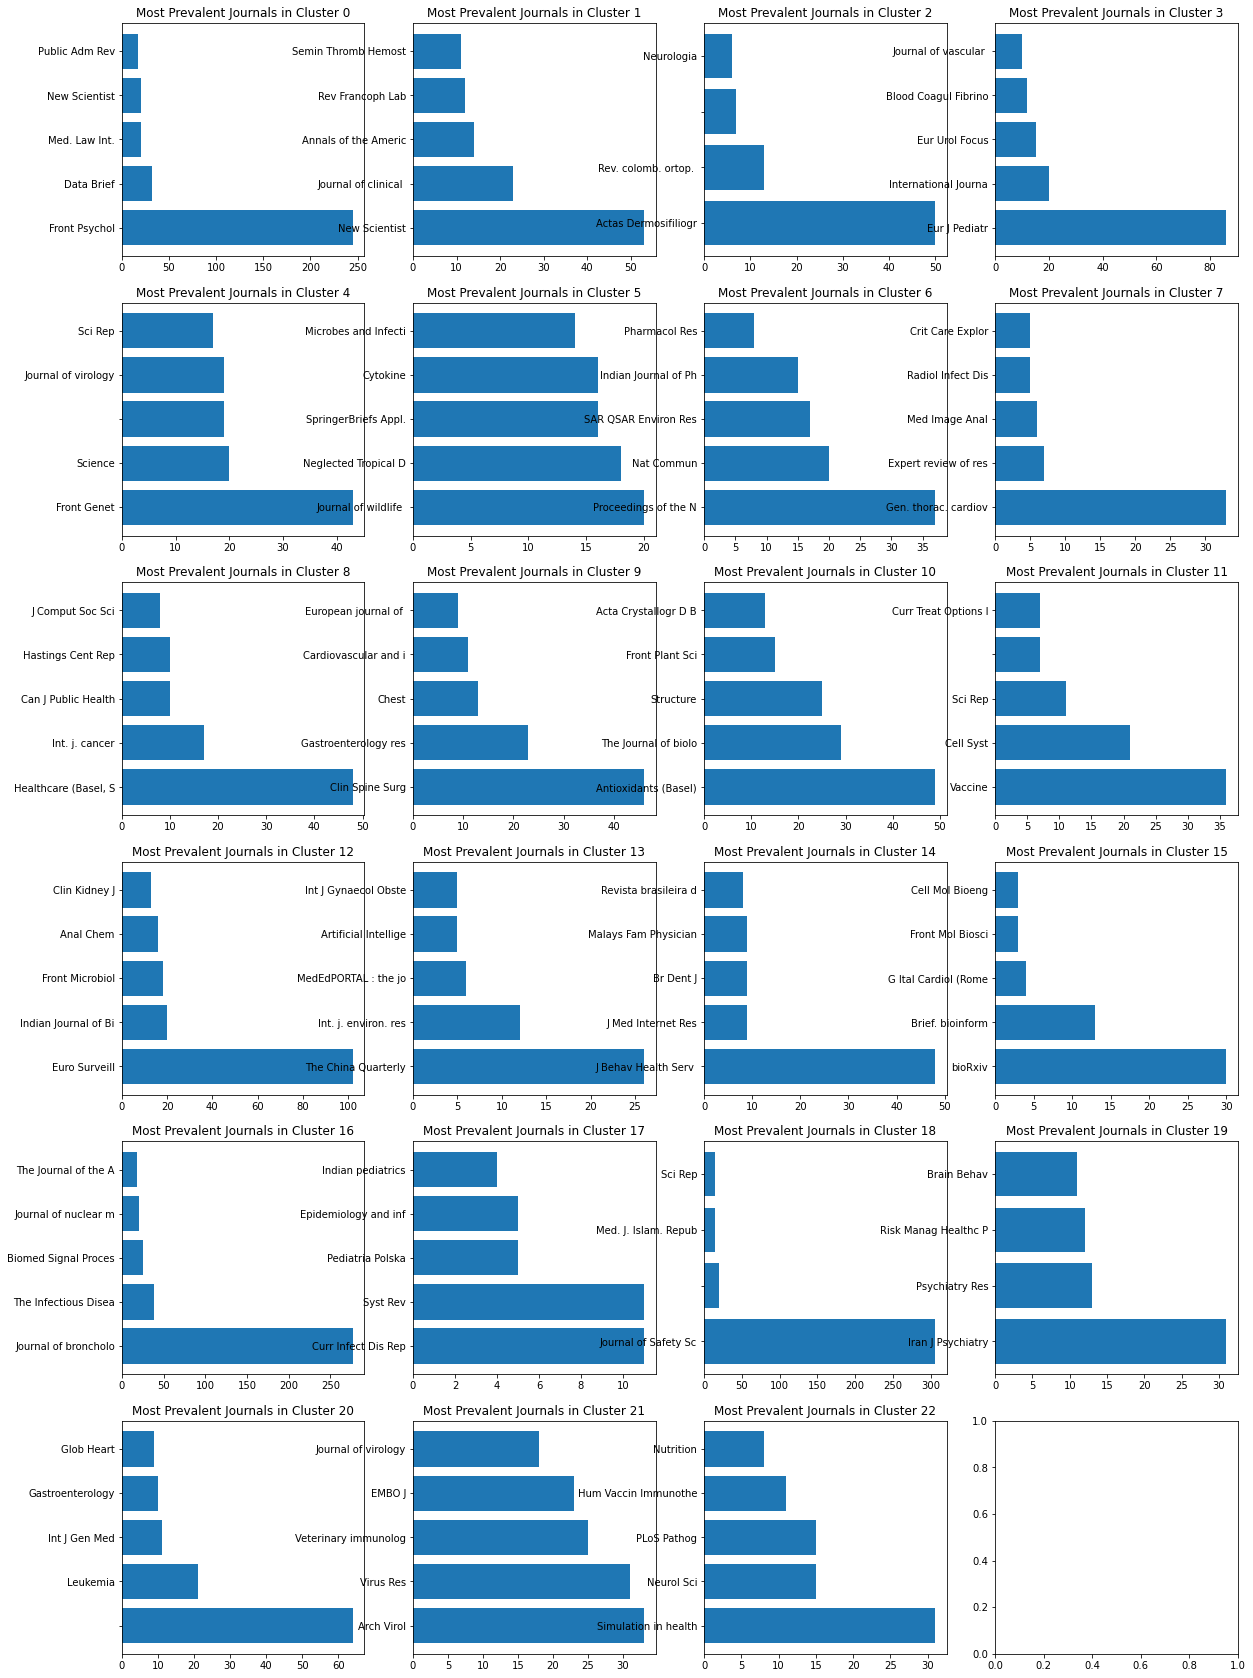

In [13]:
best_k = 23 # pick best kval

kmeans = KMeans(n_clusters=best_k, random_state=0)
kmeans.fit(matrix)
predictions = kmeans.labels_
top_journals = top_journals_per_cluster(predictions, 5)

fig, axs = plt.subplots(6,4,figsize=(20, 30))
for i in range(best_k):
    axs[i//4][i%4].set_title("Most Prevalent Journals in Cluster " + str(i))
    axs[i//4][i%4].barh(top_journals[i]['journal'].apply(lambda x: x[:20]), top_journals[i]['counts'])
plt.show()

In [14]:
# calculate number of documents per cluster
u,c = np.unique(predictions,return_counts=True)

# calculate the percentage of documents under most prevalent journal in each cluster
top_journal_percent = []
for i in range(best_k):
    top_journal_percent.append(top_journals[i]['counts'][0]/c[i])
 
# calculate number of journals that make up 50% of each cluster
numberj = []
for i in range(best_k):
    ind = np.where(predictions==i)[0] # get indices from resulting predictions with the current label
    jour = [journals[j] for j in ind] # extract the corresponding journals
    unique, counts = np.unique(jour, return_counts=True) # record the counts for each unique journal of current label
    top_id = np.argsort(counts)[::-1] # get indices of top n_journal counts
    threshold = 0.5*c[i]
    currsum = 0
    numj = 0
    for j in range(len(top_id)):
        numj += 1
        currsum += counts[top_id[j]]
        if currsum >= threshold:
            break
    numberj.append(numj)

In [15]:
keval = pd.DataFrame([(u[i],c[i],top_journals[i]['journal'][0],top_journal_percent[i],numberj[i]) for i in range(len(u))],columns=['cluster','number of docs','top journal','percent of top journal','number of journals making up 50%'])
keval

,cluster,number of docs,top journal,percent of top journal,number of journals making up 50%
0,0,2334,Front Psychol,0.104970,320
1,1,1267,New Scientist,0.041831,235
2,2,232,Actas Dermosifiliogr,0.215517,16
3,3,1335,Eur J Pediatr,0.064419,191
4,4,582,Front Genet,0.073883,34
5,5,818,Journal of wildlife diseases,0.024450,100
6,6,504,Proceedings of the National Academy of Science...,0.073413,73
7,7,329,Gen. thorac. cardiovasc. surg,0.100304,62
8,8,741,"Healthcare (Basel, Switzerland)",0.064777,123
9,9,738,Clin Spine Surg,0.062331,84


In [16]:
print(np.sum(keval['percent of top journal']))
print(np.sum(keval['number of journals making up 50%']))

2.039561232658263
2805


### Evaluate random clusters

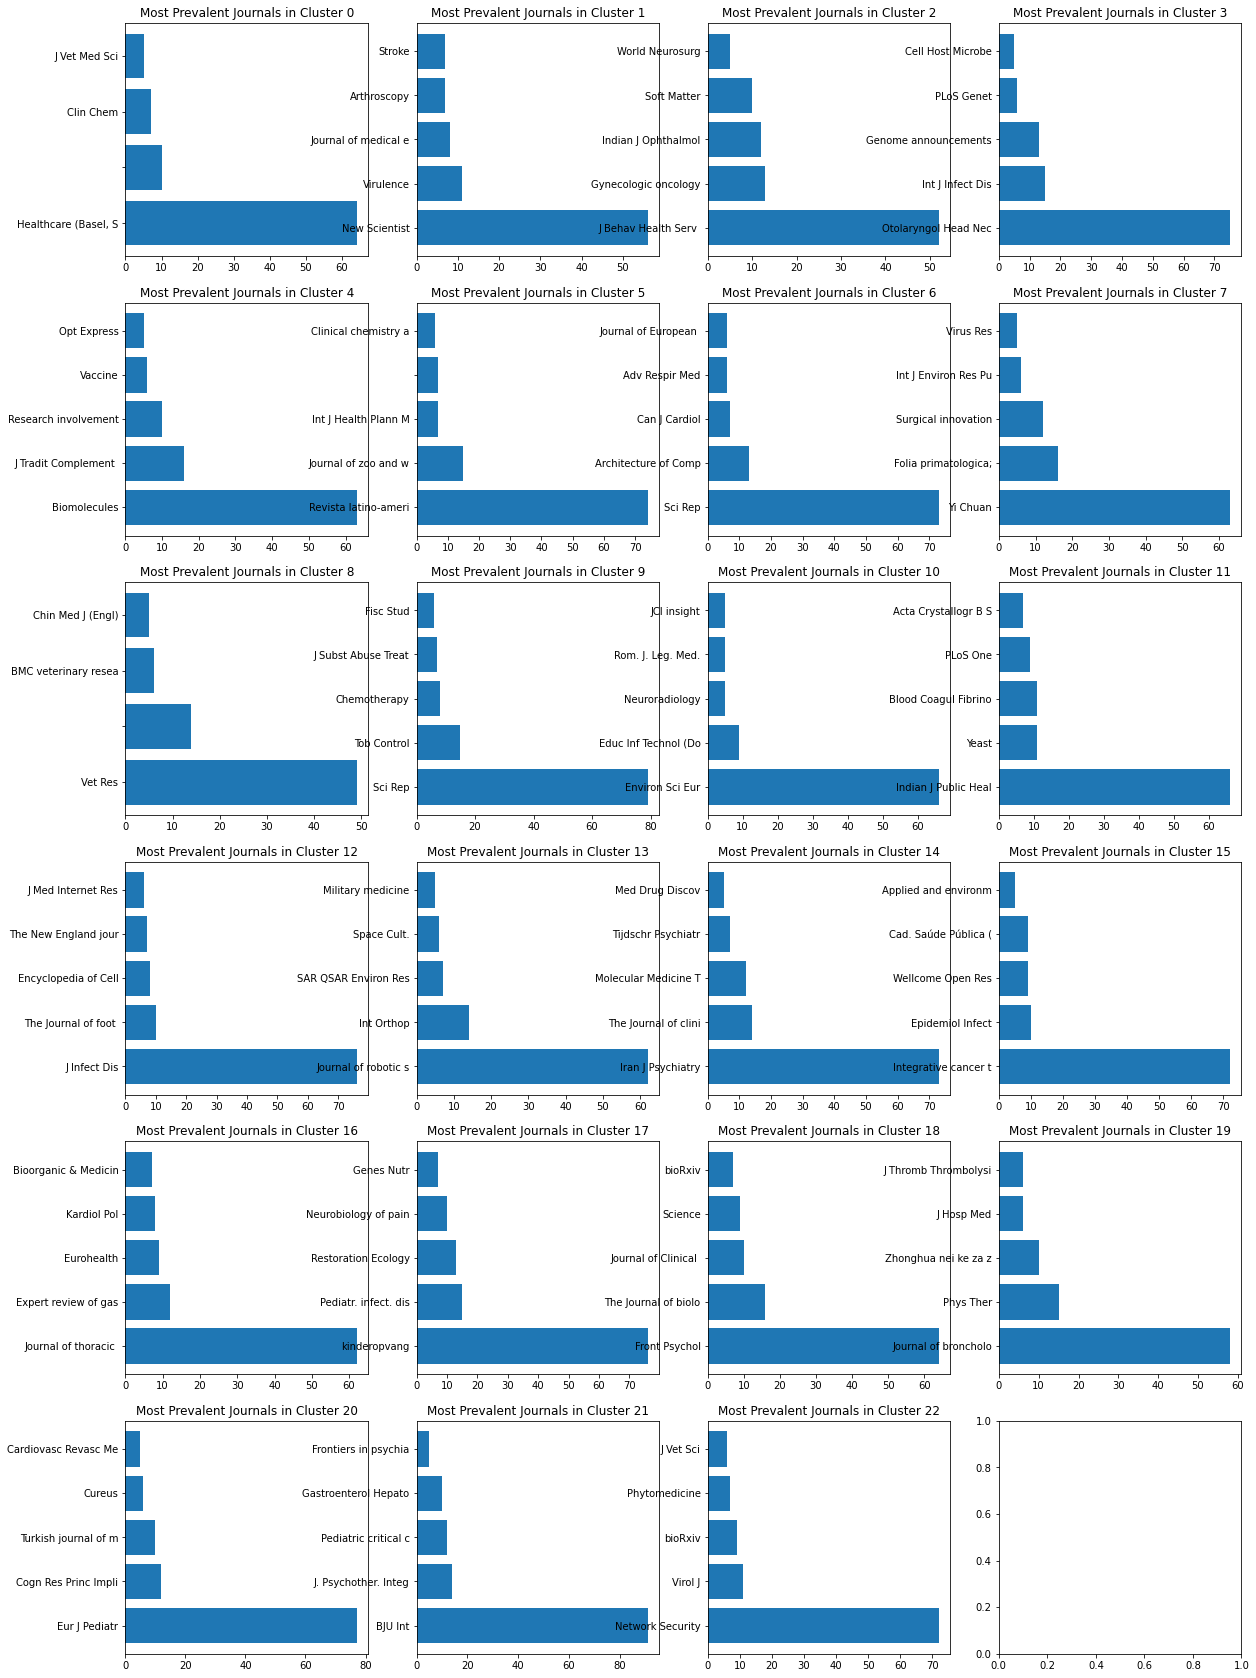

In [17]:
random_predictions = np.random.randint(23,size=predictions.shape)

random_top_journals = top_journals_per_cluster(random_predictions, 5)

fig, axs = plt.subplots(6,4,figsize=(20, 30))
for i in range(best_k):
    axs[i//4][i%4].set_title("Most Prevalent Journals in Cluster " + str(i))
    axs[i//4][i%4].barh(random_top_journals[i]['journal'].apply(lambda x: x[:20]), random_top_journals[i]['counts'])
plt.show()

In [18]:
# calculate number of documents per cluster
ru,rc = np.unique(random_predictions,return_counts=True)

# calculate the percentage of documents under most prevalent journal in each cluster
r_top_journal_percent = []
for i in range(best_k):
    r_top_journal_percent.append(random_top_journals[i]['counts'][0]/c[i])
    
# calculate number of journals that make up 50% of each cluster
numberj = []
for i in range(best_k):
    ind = np.where(random_predictions==i)[0] # get indices from resulting predictions with the current label
    jour = [journals[j] for j in ind] # extract the corresponding journals
    unique, counts = np.unique(jour, return_counts=True) # record the counts for each unique journal of current label
    top_id = np.argsort(counts)[::-1] # get indices of top n_journal counts
    threshold = 0.5*rc[i]
    currsum = 0
    numj = 0
    for j in range(len(top_id)):
        numj += 1
        currsum += counts[top_id[j]]
        if currsum >= threshold:
            break
    numberj.append(numj)

In [19]:
randeval1 = pd.DataFrame([(ru[i],rc[i],random_top_journals[i]['journal'][0],r_top_journal_percent[i],numberj[i]) for i in range(len(u))],columns=['cluster','number of docs','top journal','percent of top journal','number of journals making up 50%'])
randeval1

,cluster,number of docs,top journal,percent of top journal,number of journals making up 50%
0,0,781,"Healthcare (Basel, Switzerland)",0.027421,212
1,1,836,New Scientist,0.044199,236
2,2,894,J Behav Health Serv Res,0.224138,274
3,3,867,Otolaryngol Head Neck Surg,0.056180,238
4,4,832,Biomolecules,0.108247,242
5,5,832,Revista latino-americana de enfermagem,0.090465,232
6,6,876,Sci Rep,0.144841,250
7,7,836,Yi Chuan,0.191489,229
8,8,857,Vet Res,0.066127,253
9,9,921,Sci Rep,0.107046,242


In [20]:
print(np.sum(randeval1['percent of top journal']))
print(np.sum(randeval1['number of journals making up 50%']))

2.7642660141573967
5561


Random clustering seems to have better results in regards to how much the top journal dominates the cluster, but this may have to do with the number of documents in each cluster. In random clustering, the documents are much more evenly distributed, and each document has a bigger influence in smaller clusters than in bigger clusters. Next we will try to randomize predictions based on the cluster sizes obtained from kmeans.

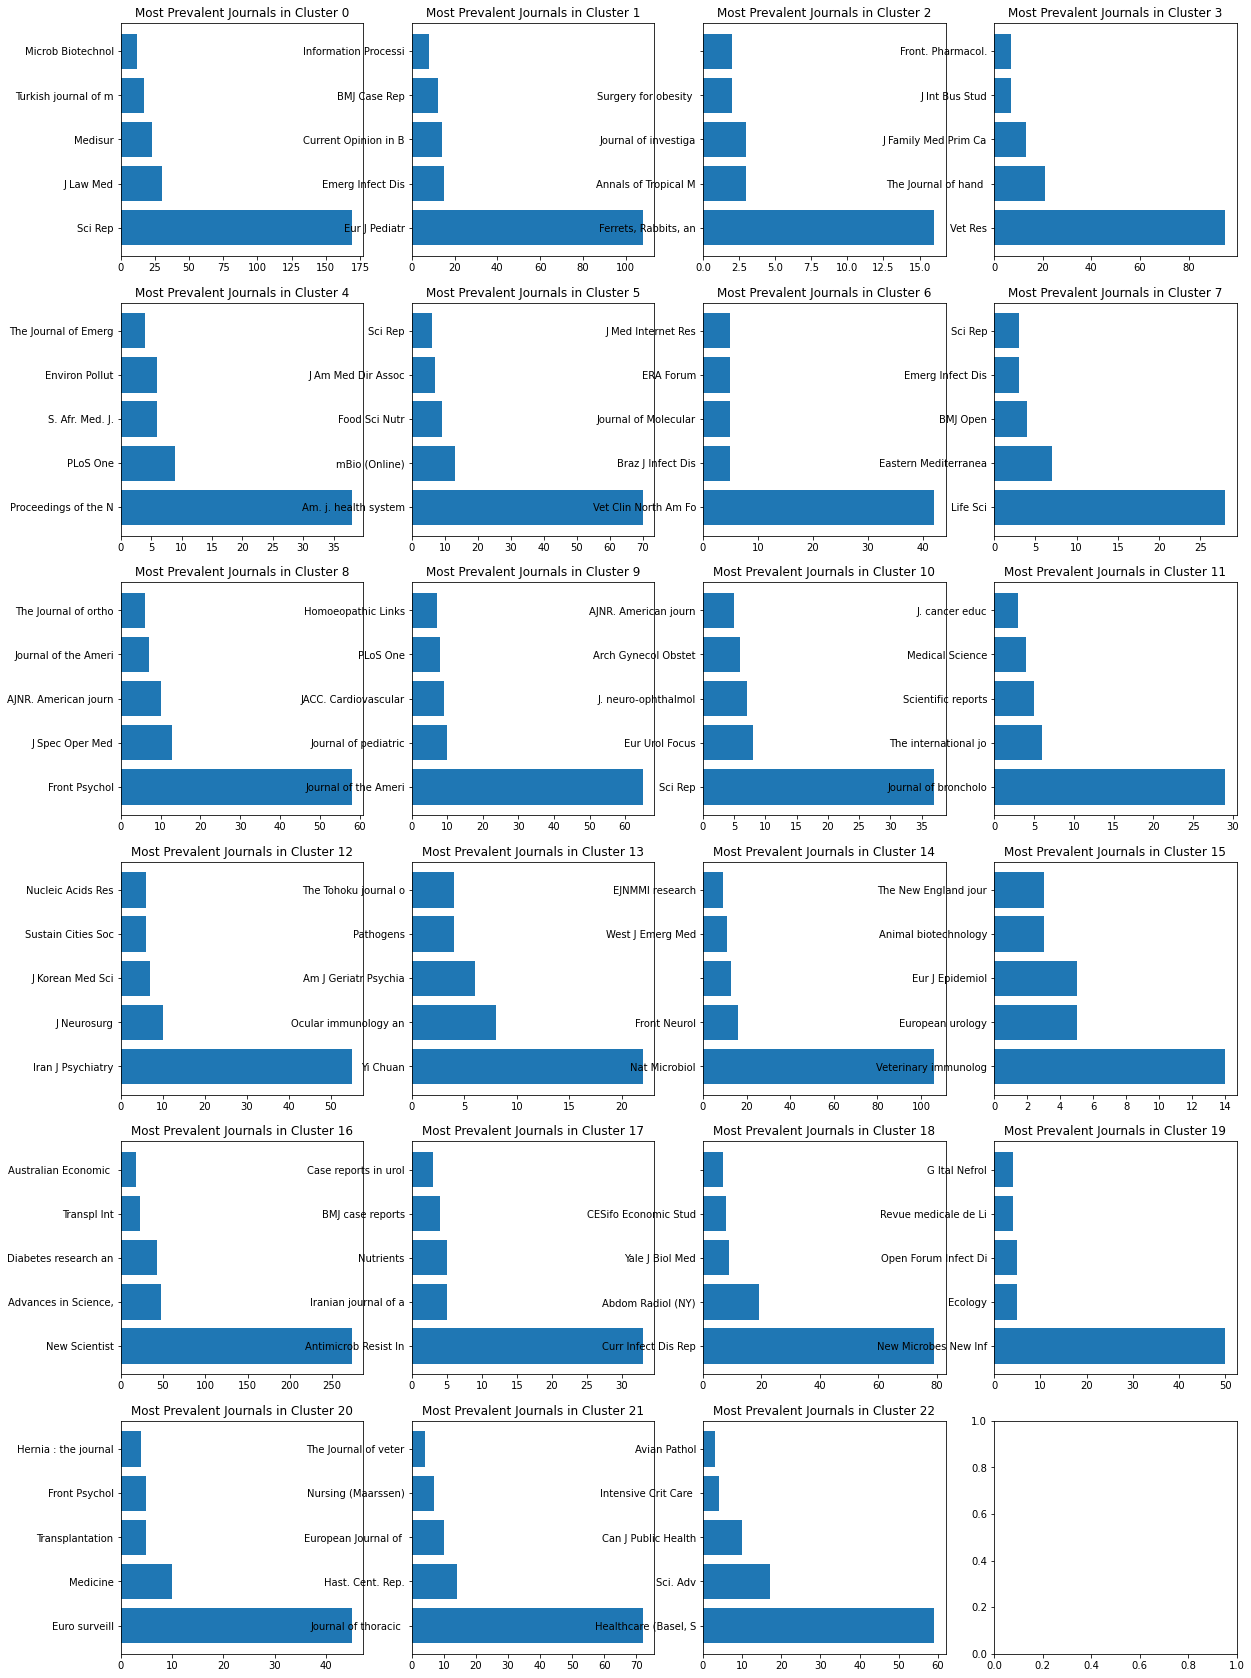

In [21]:
random_predictions = np.zeros(predictions.shape)
for i in range(best_k):
    random_predictions[np.sum(c[:i]):np.sum(c[:i+1])] = i
random.shuffle(random_predictions)

random_top_journals = top_journals_per_cluster(random_predictions, 5)

fig, axs = plt.subplots(6,4,figsize=(20, 30))
for i in range(best_k):
    axs[i//4][i%4].set_title("Most Prevalent Journals in Cluster " + str(i))
    axs[i//4][i%4].barh(random_top_journals[i]['journal'].apply(lambda x: x[:20]), random_top_journals[i]['counts'])
plt.show()

In [22]:
# calculate number of documents per cluster
ru,rc = np.unique(random_predictions,return_counts=True)

# calculate the percentage of documents under most prevalent journal in each cluster
r_top_journal_percent = []
for i in range(best_k):
    r_top_journal_percent.append(random_top_journals[i]['counts'][0]/c[i])

# calculate number of journals that make up 50% of each cluster
numberj = []
for i in range(best_k):
    ind = np.where(random_predictions==i)[0] # get indices from resulting predictions with the current label
    jour = [journals[j] for j in ind] # extract the corresponding journals
    unique, counts = np.unique(jour, return_counts=True) # record the counts for each unique journal of current label
    top_id = np.argsort(counts)[::-1] # get indices of top n_journal counts
    threshold = 0.5*rc[i]
    currsum = 0
    numj = 0
    for j in range(len(top_id)):
        numj += 1
        currsum += counts[top_id[j]]
        if currsum >= threshold:
            break
    numberj.append(numj)

In [23]:
randeval2 = pd.DataFrame([(ru[i],rc[i],random_top_journals[i]['journal'][0],r_top_journal_percent[i], numberj[i]) for i in range(len(u))],columns=['cluster','number of docs','top journal','percent of top journal','number of journals making up 50%'])
randeval2

,cluster,number of docs,top journal,percent of top journal,number of journals making up 50%
0,0.0,2334,Sci Rep,0.072408,401
1,1.0,1267,Eur J Pediatr,0.085241,314
2,2.0,232,"Ferrets, Rabbits, and Rodents",0.068966,92
3,3.0,1335,Vet Res,0.071161,338
4,4.0,582,Proceedings of the National Academy of Science...,0.065292,180
5,5.0,818,Am. j. health system pharm,0.085575,229
6,6.0,504,Vet Clin North Am Food Anim Pract,0.083333,165
7,7.0,329,Life Sci,0.085106,104
8,8.0,741,Front Psychol,0.078273,205
9,9.0,738,Journal of the American Heart Association,0.088076,197


In [24]:
print(np.sum(randeval2['percent of top journal']))
print(np.sum(randeval2['number of journals making up 50%']))

1.795458856012118
4932


## Cluster Analysis

In [25]:
def top_features_per_cluster(matrix, predictions, n_features):
    res = []
    labels = np.unique(predictions)
    for label in labels:
        avg_score = np.mean(matrix[np.where(predictions==label)], axis=0).getA1() # calculate average tf-idf score for current label
        top_id = np.argsort(avg_score)[::-1][:n_features] # get indices of top n_features scores
        top_feat_score = [(features[i], avg_score[i]) for i in top_id] # store feature name (word) and score for the top n_features
        df = pd.DataFrame(top_feat_score,columns=['feature','score'])
        res.append(df)
    return res

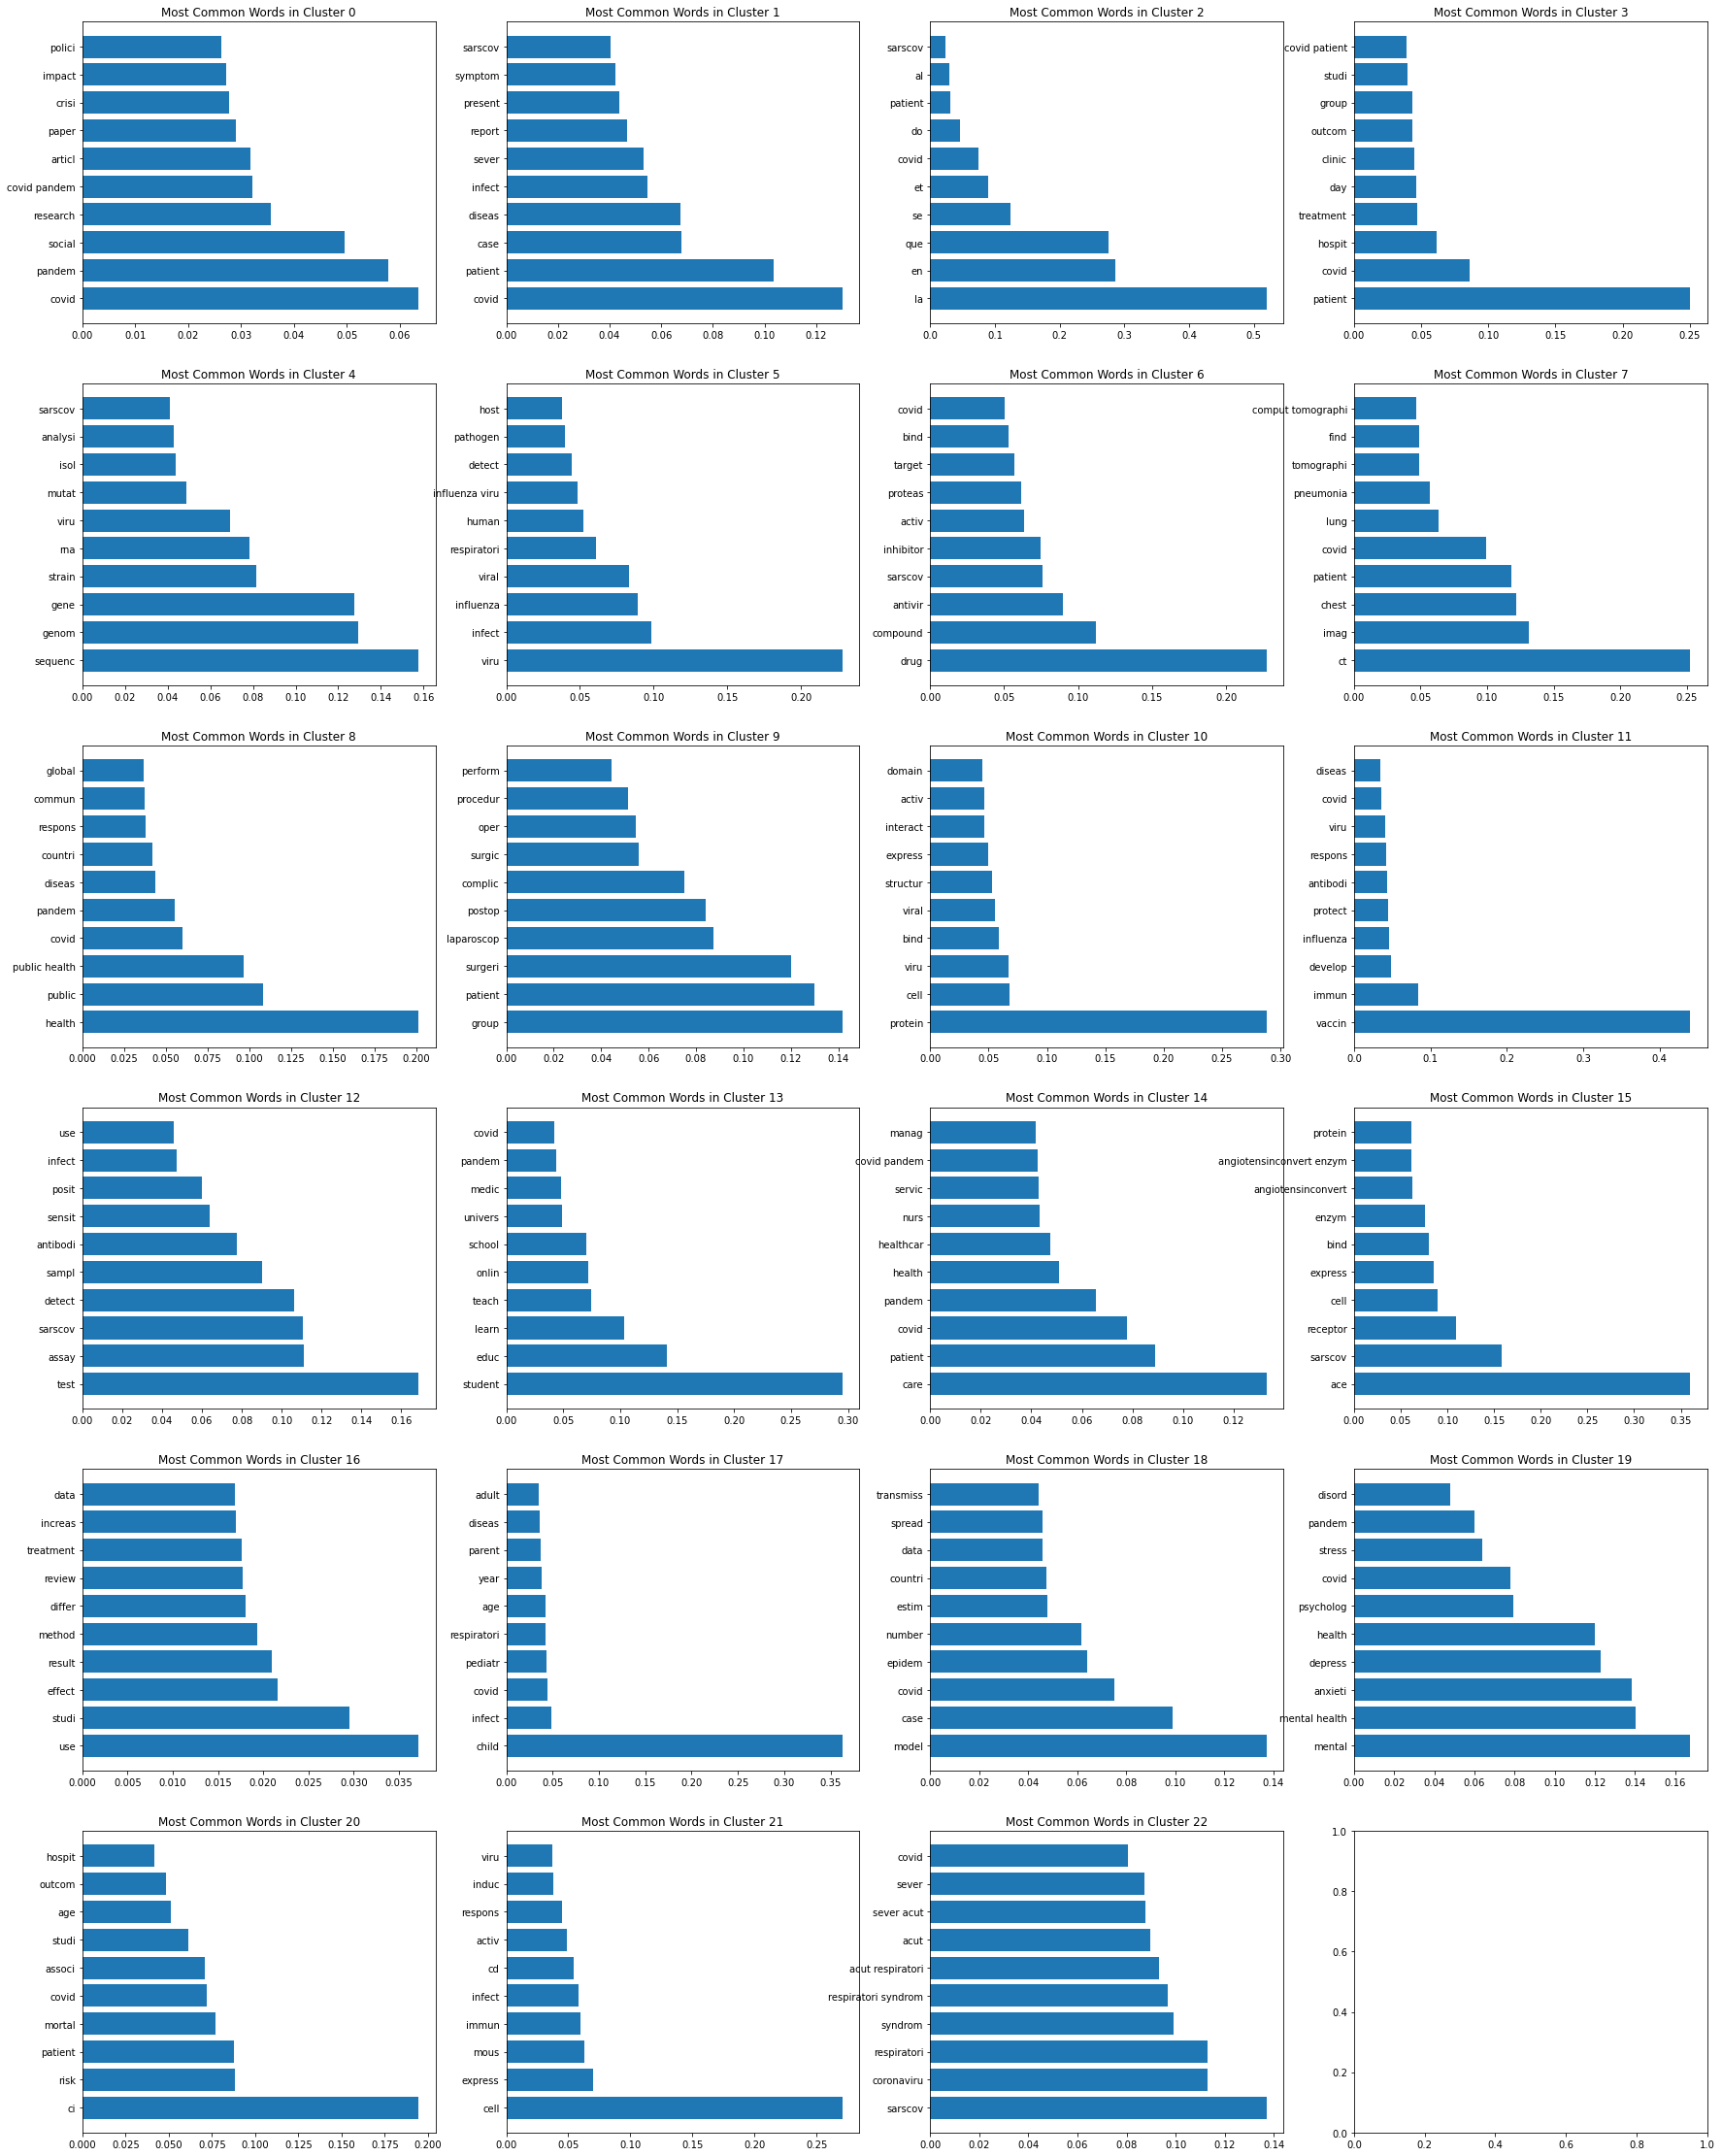

In [26]:
best_k = 23 # pick best kval

kmeans = KMeans(n_clusters=best_k, random_state=0)
kmeans.fit(matrix)
predictions = kmeans.labels_
top_words = top_features_per_cluster(matrix, predictions, 10)

fig, axs = plt.subplots(6,4,figsize=(30, 40))
for i in range(best_k):
    axs[i//4][i%4].set_title("Most Common Words in Cluster " + str(i))
    axs[i//4][i%4].barh(top_words[i]['feature'], top_words[i]['score'])
plt.show()

# Agglomerative Clustering

In [27]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

# setting distance_threshold=0 ensures we compute the full tree.
fulltree_model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
fulltree_model.fit(matrix)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

In [28]:
#calculating linkage matrix to display dendrogram
counts = np.zeros(fulltree_model.children_.shape[0])
n_samples = len(fulltree_model.labels_)
for i, merge in enumerate(fulltree_model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([fulltree_model.children_, fulltree_model.distances_,
                                      counts]).astype(float)

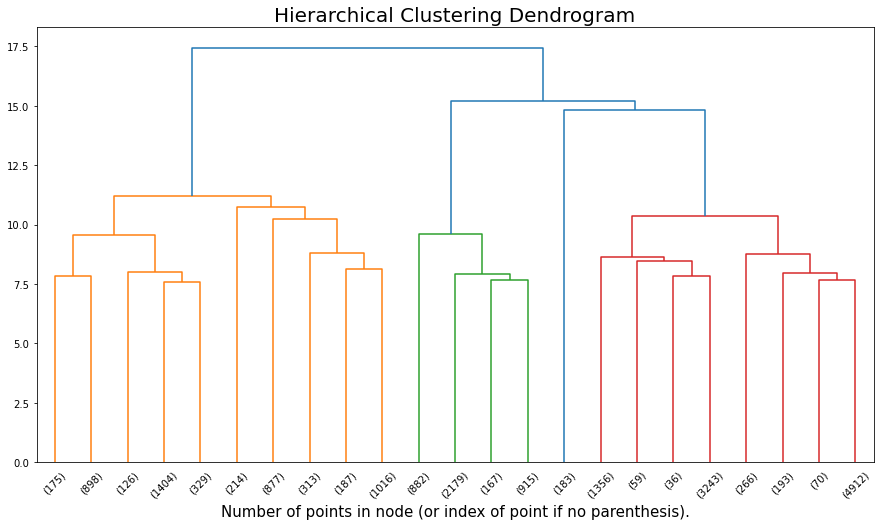

In [29]:
# Plot the dendrogram
fig,axs = plt.subplots(1,1,figsize=(15,8))
dendrogram(linkage_matrix, truncate_mode='lastp', p=23, ax=axs)
plt.title('Hierarchical Clustering Dendrogram',fontsize=20)
plt.xlabel("Number of points in node (or index of point if no parenthesis).", fontsize=15)
plt.show()

In [30]:
agg = AgglomerativeClustering(n_clusters=23)
agg.fit(matrix)

AgglomerativeClustering(n_clusters=23)

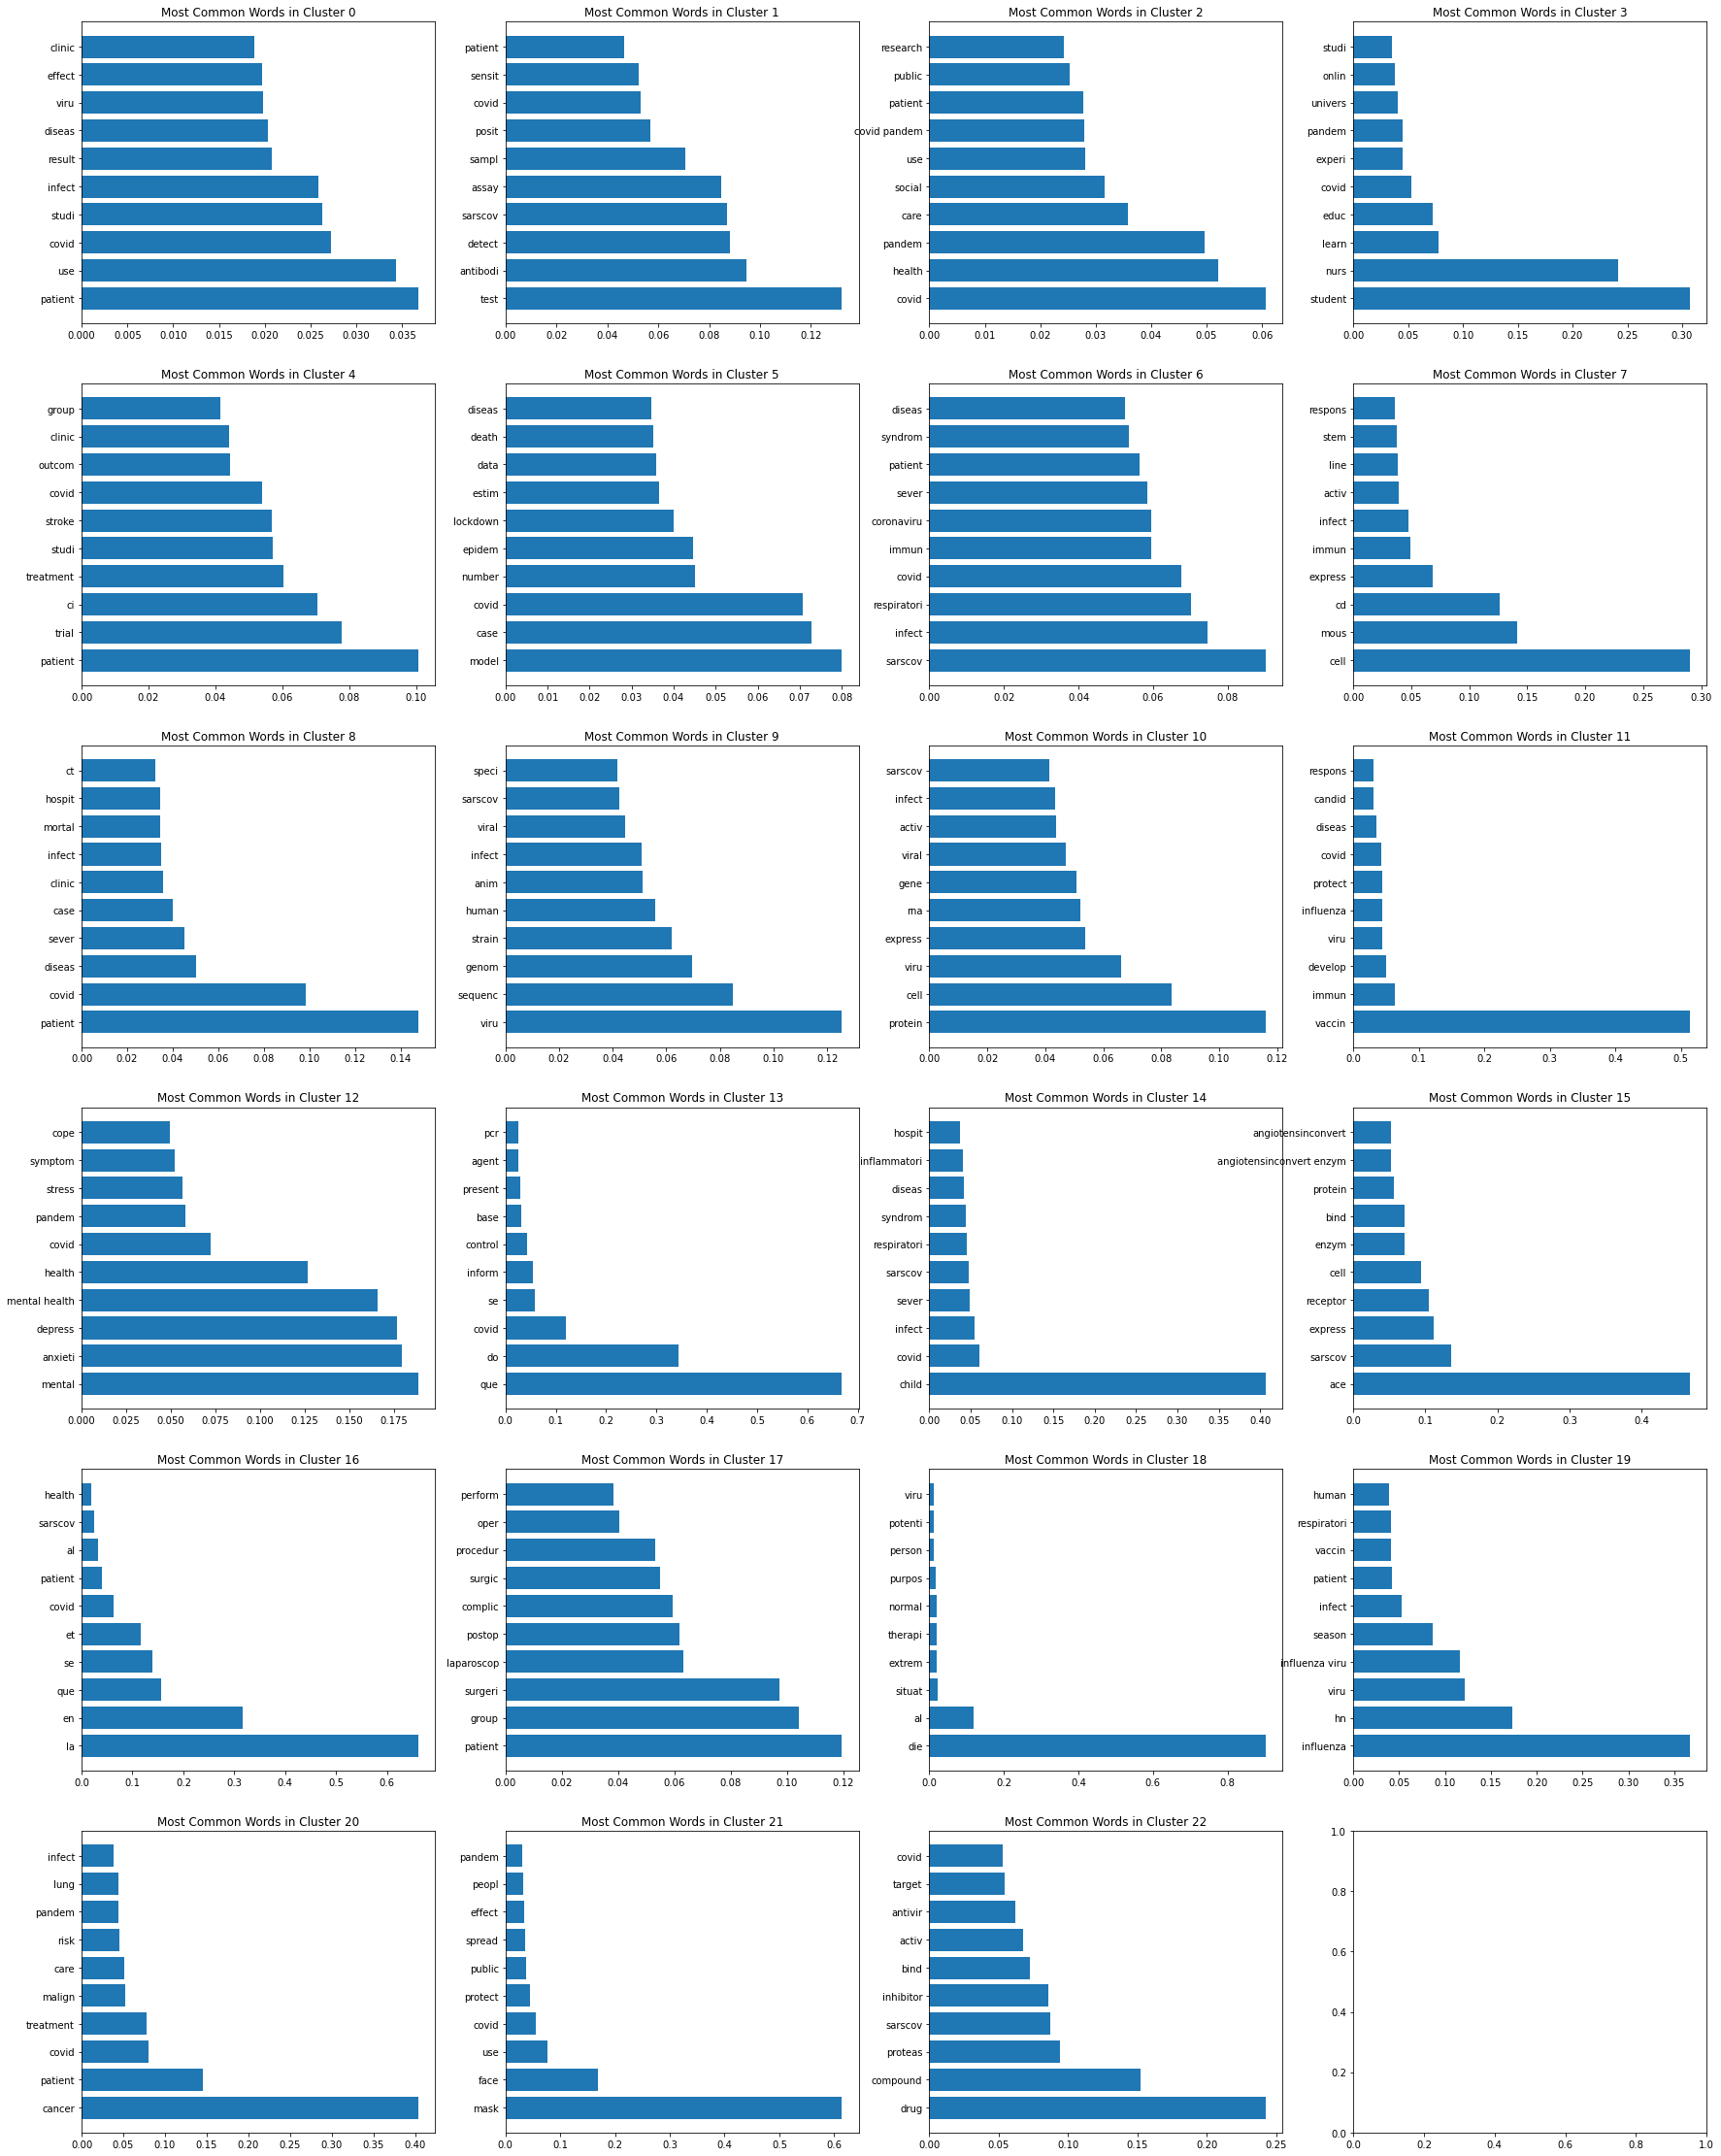

In [31]:
best_k=23
predictions=agg.labels_

top_words = top_features_per_cluster(matrix, predictions, 10)

fig, axs = plt.subplots(6,4,figsize=(30, 40))
for i in range(best_k):
    axs[i//4][i%4].set_title("Most Common Words in Cluster " + str(i))
    axs[i//4][i%4].barh(top_words[i]['feature'], top_words[i]['score'])
plt.show()

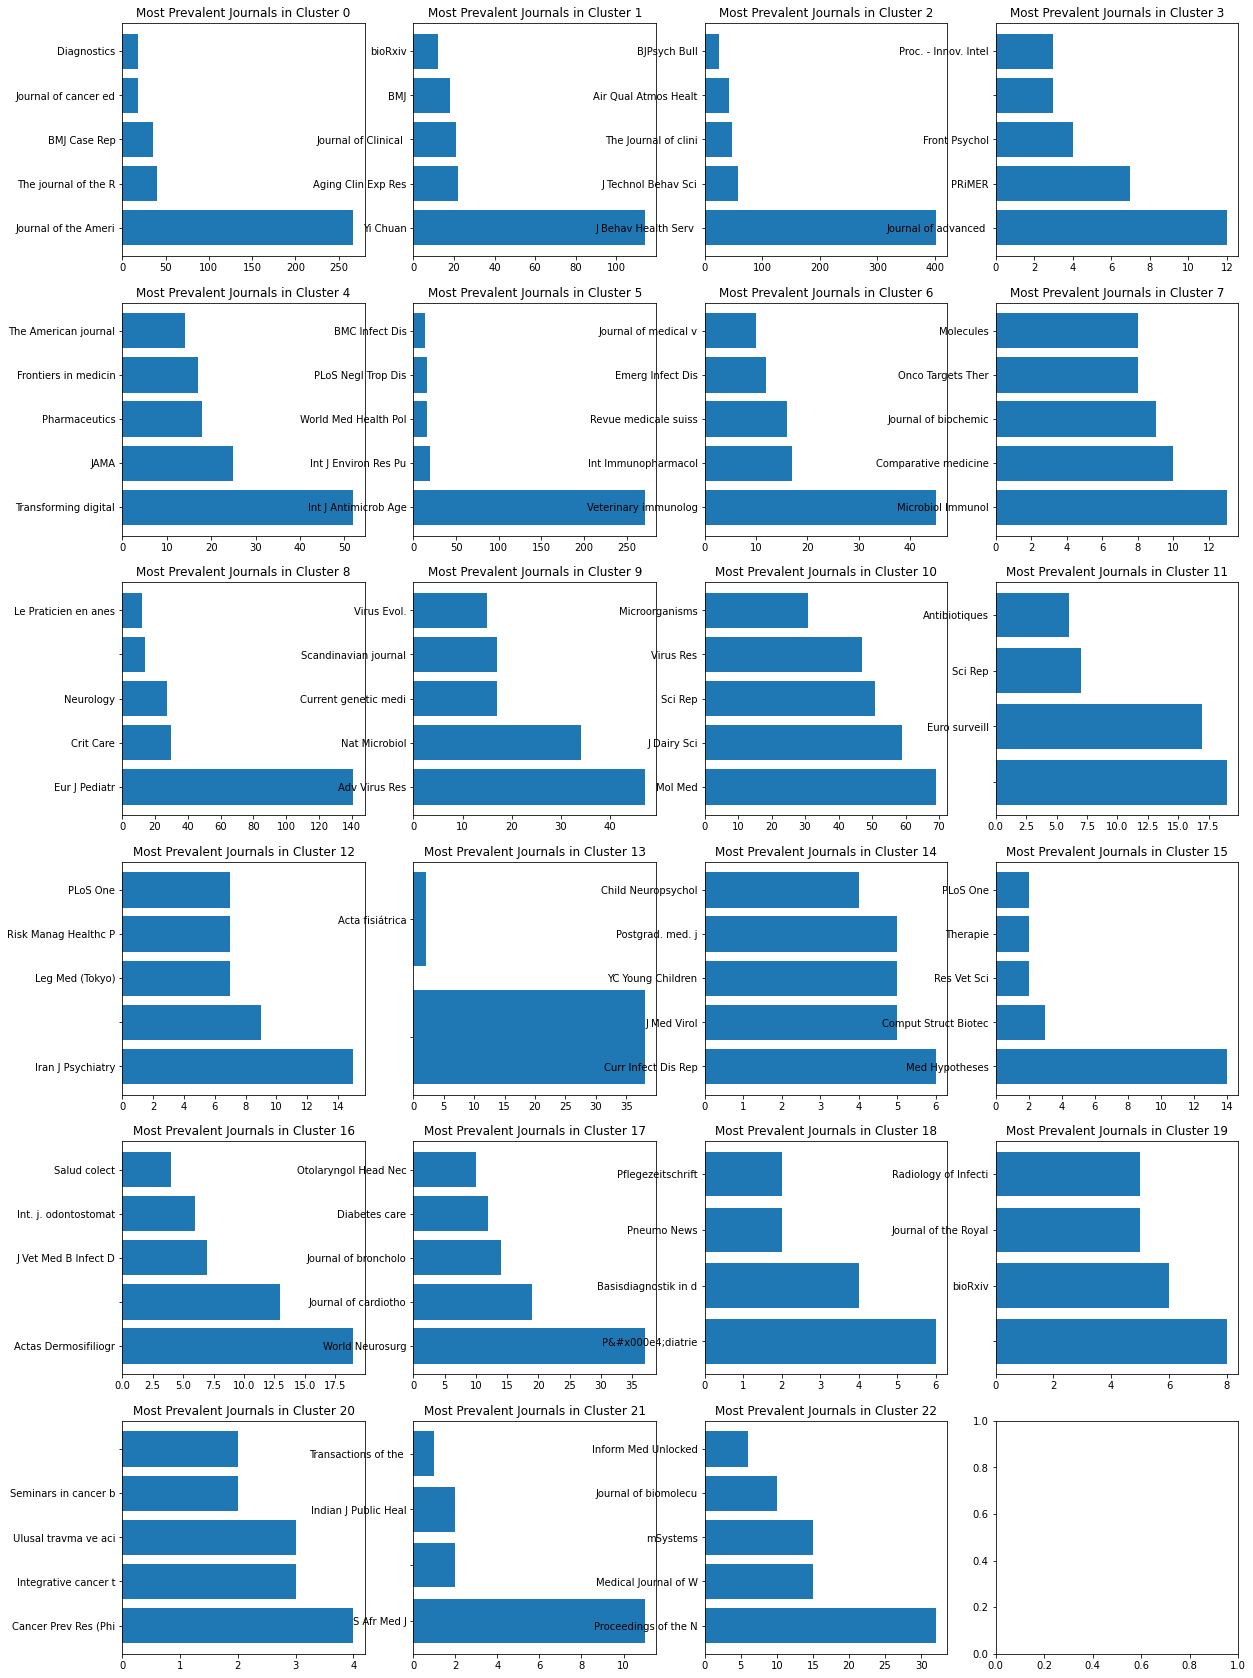

In [32]:
top_journals = top_journals_per_cluster(predictions, 5)

fig, axs = plt.subplots(6,4,figsize=(20, 30))
for i in range(best_k):
    axs[i//4][i%4].set_title("Most Prevalent Journals in Cluster " + str(i))
    axs[i//4][i%4].barh(top_journals[i]['journal'].apply(lambda x: x[:20]), top_journals[i]['counts'])
plt.show()

In [33]:
# calculate number of documents per cluster
u,c = np.unique(predictions,return_counts=True)

# calculate the percentage of documents under most prevalent journal in each cluster
top_journal_percent = []
for i in range(best_k):
    top_journal_percent.append(top_journals[i]['counts'][0]/c[i])
 
# calculate number of journals that make up 50% of each cluster
numberj = []
for i in range(best_k):
    ind = np.where(predictions==i)[0] # get indices from resulting predictions with the current label
    jour = [journals[j] for j in ind] # extract the corresponding journals
    unique, counts = np.unique(jour, return_counts=True) # record the counts for each unique journal of current label
    top_id = np.argsort(counts)[::-1] # get indices of top n_journal counts
    threshold = 0.5*c[i]
    currsum = 0
    numj = 0
    for j in range(len(top_id)):
        numj += 1
        currsum += counts[top_id[j]]
        if currsum >= threshold:
            break
    numberj.append(numj)

In [35]:
print(np.sum(aggeval['percent of top journal']))
print(np.sum(aggeval['number of journals making up 50%']))

2.4367413523817665
2619


CLUSTER 16 joins dendrogram late, not much meaning in common words in this cluster

ORANGE: 1, 6, 7, 9, 10, 11, 14, 15, 19, 22 -- biological (virus, vaccine, drug, protein, etc.)

GREEN: 4, 8, 17, 20 -- medical (covid, patient, cancer, treatment, surgery)

RED: 0, 2, 3, 5, 12, 13, 18, 21 -- healthcare (mask, mental health, student, patient, care)

# Silhouette index experimentation with dummy datasets

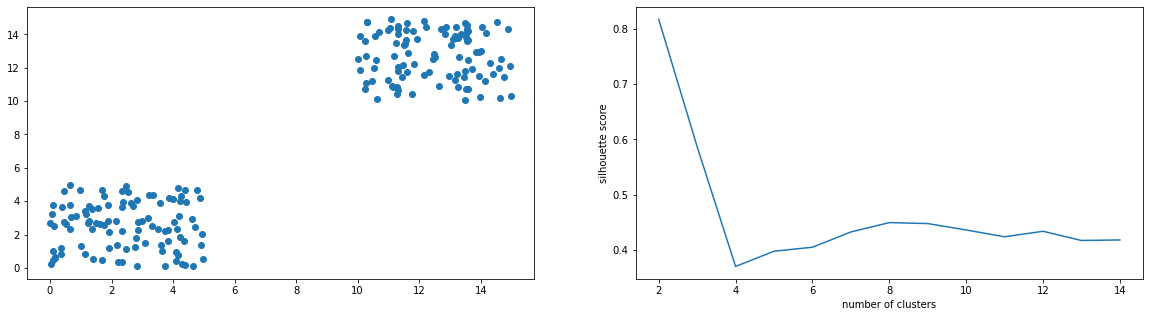

In [45]:
# two distinct clusters
# expect high score for k=2

x1 = np.concatenate((np.random.rand(100)*5, np.random.rand(100)*5+10))
y1 = np.concatenate((np.random.rand(100)*5, np.random.rand(100)*5+10))
m = np.vstack((x1,y1)).T
kvals = np.arange(2,15)
scores = []
for k in kvals:
    model = KMeans(n_clusters=k, random_state=0)
    model.fit(m)
    score = silhouette_score(m, model.labels_)
    scores.append(score)
fig,axs = plt.subplots(1,2,figsize=(20,5))
axs[0].scatter(x1,y1)
axs[1].plot(kvals,scores)
axs[1].set_xlabel('number of clusters')
axs[1].set_ylabel('silhouette score')
plt.show()

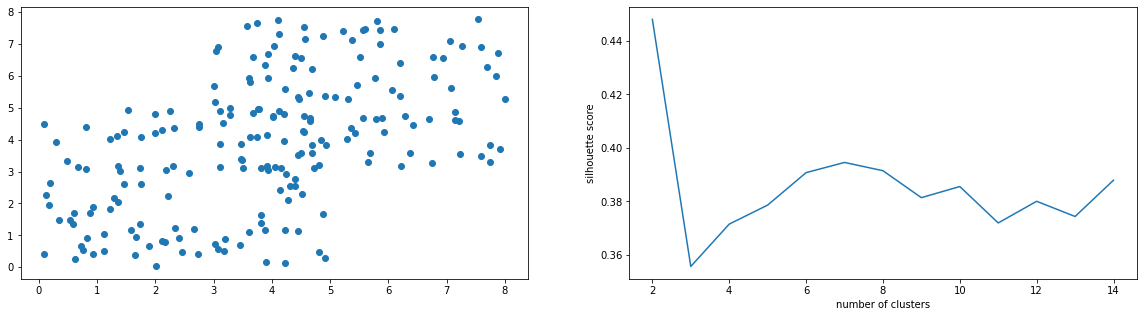

In [12]:
# two clusters overlapping
# still expect a relatively high score for k=2 but lower than above cell

x2 = np.concatenate((np.random.rand(100)*5, np.random.rand(100)*5+3))
y2 = np.concatenate((np.random.rand(100)*5, np.random.rand(100)*5+3))
m = np.vstack((x2,y2)).T
kvals = np.arange(2,15)
scores = []
for k in kvals:
    model = KMeans(n_clusters=k, random_state=0)
    model.fit(m)
    score = silhouette_score(m, model.labels_)
    scores.append(score)
fig,axs = plt.subplots(1,2,figsize=(20,5))
axs[0].scatter(x2,y2)
axs[1].plot(kvals,scores)
axs[1].set_xlabel('number of clusters')
axs[1].set_ylabel('silhouette score')
plt.show()

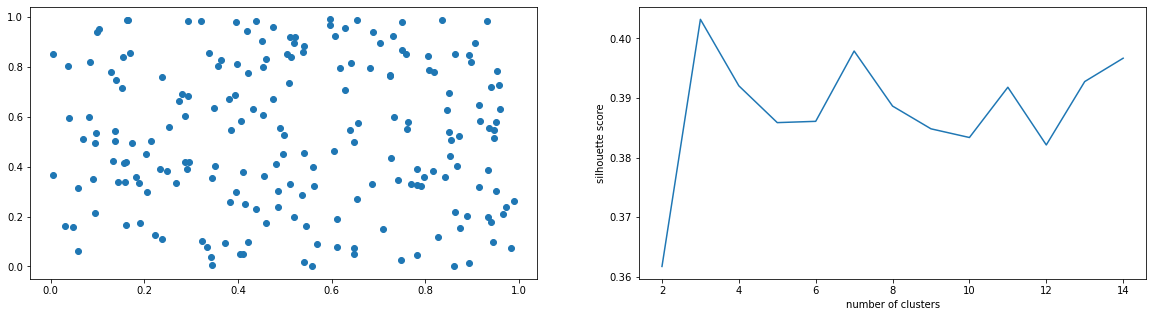

In [13]:
# random set of points

x3 = np.random.rand(200)
y3 = np.random.rand(200)
m = np.vstack((x3,y3)).T
kvals = np.arange(2,15)
scores = []
for k in kvals:
    model = KMeans(n_clusters=k, random_state=0)
    model.fit(m)
    score = silhouette_score(m, model.labels_)
    scores.append(score)
fig,axs = plt.subplots(1,2,figsize=(20,5))
axs[0].scatter(x3,y3)
axs[1].plot(kvals,scores)
axs[1].set_xlabel('number of clusters')
axs[1].set_ylabel('silhouette score')
plt.show()

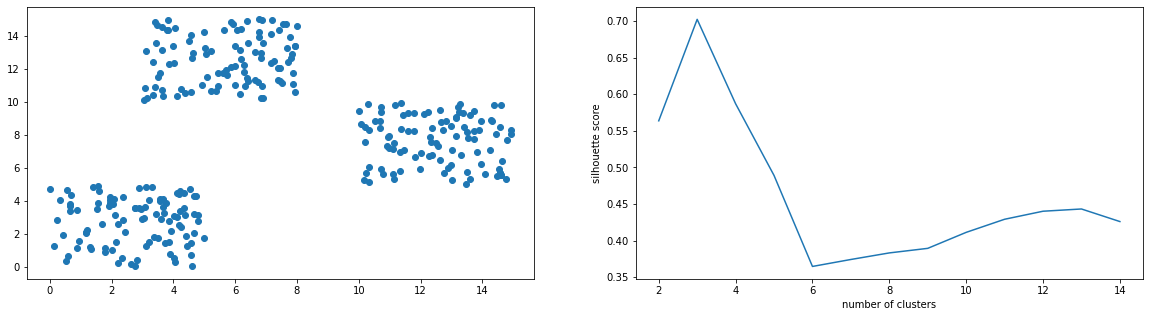

In [11]:
# three distinct clusters
# expect high score for k=3

x1 = np.concatenate((np.random.rand(100)*5, np.random.rand(100)*5+3, np.random.rand(100)*5+10))
y1 = np.concatenate((np.random.rand(100)*5, np.random.rand(100)*5+10, np.random.rand(100)*5+5))
m = np.vstack((x1,y1)).T
kvals = np.arange(2,15)
scores = []
for k in kvals:
    model = KMeans(n_clusters=k, random_state=0)
    model.fit(m)
    score = silhouette_score(m, model.labels_)
    scores.append(score)
fig,axs = plt.subplots(1,2,figsize=(20,5))
axs[0].scatter(x1,y1)
axs[1].plot(kvals,scores)
axs[1].set_xlabel('number of clusters')
axs[1].set_ylabel('silhouette score')
plt.show()